In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch_harmonics as th
import xarray as xr
from scipy.stats.qmc import Halton

data = xr.open_zarr(
    "/mnt/home/gkrawezik/ceph/AI_DATASETS/WeatherBench2/1959-2022-6h-1440x721.zarr/"
)

In [9]:
def create_downsample(in_lat, in_lon, out_lat, out_lon):
    forward = th.RealSHT(in_lat, in_lon, grid="equiangular")
    backward = th.InverseRealSHT(out_lat, out_lon, grid="equiangular")

    def inner(data):
        with torch.no_grad():
            data = forward(data)
            data = data[..., :out_lat, : out_lon // 2 + 1]
            data = backward(data)
        return data

    return inner


downsample = create_downsample(721, 1440, 256, 512)

In [10]:
oro = torch.tensor(data["geopotential_at_surface"][:].data / 9.80616)
oro = oro.sign() * oro.abs() ** (15 / 16)  # .sqrt()
oro = downsample(oro)
oro = oro - oro.min()
IC_dir = "../data_stubs/"
n_ICs = 40

generator = Halton(1, seed=54321)
ic_indices = generator.random(n_ICs)

index = 0
for ic in ic_indices:
    int_ic = int(ic[0] * data.time.shape[0])
    h = downsample(
        torch.tensor(data["geopotential"].sel(level=500).isel(time=int_ic).data)
    )
    u = downsample(
        torch.tensor(data["u_component_of_wind"].sel(level=500).isel(time=int_ic).data)
    )
    v = downsample(
        torch.tensor(data["v_component_of_wind"].sel(level=500).isel(time=int_ic).data)
    )
    constructed_ic = torch.stack([u, v, h, oro], dim=0)
    np.save(f"{IC_dir}IC_{str(index).zfill(2)}.npy", constructed_ic.numpy())
    index += 1

In [13]:
oro.max()

tensor(3411.0012)

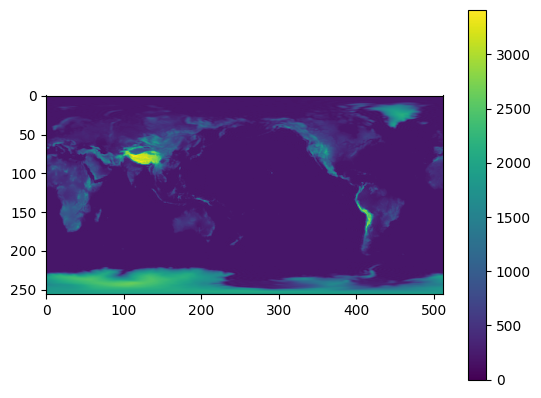

In [14]:
plt.imshow(oro)
plt.colorbar()

In [30]:
oro.min()

tensor(-304.4852)

In [13]:
data

<xarray.Dataset>
Dimensions:                                           (time: 92044,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 13)
Coordinates:
  * latitude                                          (latitude) float32 90.0...
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float32 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 ...
    10m_v_component_of_wind                           (time, latitude, longitude) float32 ...
    10m_wind_speed                                    (time, latitude, longitude) float32 ...
    2m_temperature                                    (time, latitude, longitude) float32 ...
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 ...
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 ...
    ...                                                ...
    type_of_high_vegetation                           (latitude, longitude) float32 ...
    type_of_low_vegetation                            (latitude, longitude) float32 ...
    u_component_of_wind                               (time, level, latitude, longitude) float32 ...
    v_component_of_wind                               (time, level, latitude, longitude) float32 ...
    vertical_velocity                                 (time, level, latitude, longitude) float32 ...
    wind_speed                                        (time, level, latitude, longitude) float32 ...